In [25]:
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt


In [26]:
# Set pandas to display numbers normally (not in scientific notation)
pd.set_option('display.float_format', '{:.6f}'.format)

# Disable scientific notation globally in matplotlib
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['axes.formatter.use_locale'] = False

### Function to get the conversion rate from BTC to USD

In [36]:

def get_btc_to_usd_conversion_rate():
    url = "https://api.coingecko.com/api/v3/simple/price?ids=bitcoin&vs_currencies=usd"
    response = requests.get(url)

    if response.status_code == 200:
        btc_price = response.json().get('bitcoin', {}).get('usd', None)
        if btc_price is not None:
            return btc_price
        else:
            print("Error: Unable to fetch BTC to USD conversion rate.")
    else:
        print(f"Error: API request failed with status code {response.status_code}")

    return None

## Function to extract addresses involved in the transactions

In [28]:

def extract_addresses(transactions, target_address, btc_to_usd_rate):
    involved_addresses = []
    transactions_data = []

    if btc_to_usd_rate is None:
        print("Error: BTC to USD conversion rate is not available.")
        return [], []

    for tx in transactions:
        txid = tx['txid']
        tx_time = datetime.fromtimestamp(tx['status']['block_time'])
        tx_addresses = set()
        direction = None

        for vin in tx['vin']:
            amount_satoshi = vin['prevout']['value']
            amount_btc = amount_satoshi / 1e8
            amount_usd = amount_btc * btc_to_usd_rate
            vin_address = vin['prevout'].get('scriptpubkey_address')
            if vin_address == target_address:
                direction = "Outgoing"
            tx_addresses.add((vin_address, direction))

        for vout in tx['vout']:
            amount_satoshi = vout['value']
            amount_btc = amount_satoshi / 1e8
            amount_usd = amount_btc * btc_to_usd_rate
            vout_address = vout.get('scriptpubkey_address')
            if vout_address == target_address:
                direction = "Incoming"
            tx_addresses.add((vout_address, direction))

        involved_addresses.extend(tx_addresses)

        transactions_data.append({
            'txid': txid,
            'time': tx_time,
            'direction': direction,
            'amount_satoshi': amount_satoshi,
            'amount_btc': amount_btc,
            'amount_usd': amount_usd,
            'wallet_address': target_address
        })

    return involved_addresses, transactions_data

## Function to combine all transactions of addresses belonging to a particular organization

In [29]:
def get_transactions_for_organization(address_list, btc_to_usd_rate):
    combined_transactions_data = []

    for address in address_list:
        transactions = get_transactions(address)

        if transactions:
            _, transactions_data = extract_addresses(transactions, address, btc_to_usd_rate)
            combined_transactions_data.extend(transactions_data)

    return combined_transactions_data

In [30]:
# Function to get all transactions for a given BTC address
def get_transactions(address):
    base_url = 'https://btcscan.org/api'
    txs_endpoint = f'/address/{address}/txs/chain'
    all_transactions = []
    last_seen_txid = ''

    while True:
        url = f"{base_url}{txs_endpoint}"
        if last_seen_txid:
            url += f'/{last_seen_txid}'

        response = requests.get(url)

        if response.status_code != 200:
            print(f"Error: {response.status_code}")
            break

        transactions = response.json()
        if not transactions:
            break

        all_transactions.extend(transactions)
        last_seen_txid = transactions[-1]['txid']

        if len(transactions) < 25:
            break

    return all_transactions

## Function to calculate statistics for an organization

In [31]:
def calculate_stats_for_organization(transactions_data):
    df = pd.DataFrame(transactions_data)

    total_incoming = df[df['direction'] == 'Incoming']['amount_usd'].sum()
    median_incoming = df[df['direction'] == 'Incoming']['amount_usd'].median()
    avg_incoming = df[df['direction'] == 'Incoming']['amount_usd'].mean()

    total_outgoing = df[df['direction'] == 'Outgoing']['amount_usd'].sum()
    median_outgoing = df[df['direction'] == 'Outgoing']['amount_usd'].median()
    avg_outgoing = df[df['direction'] == 'Outgoing']['amount_usd'].mean()

    total_transactions = len(df)

    return total_incoming, median_incoming, avg_incoming, total_outgoing, median_outgoing, avg_outgoing, total_transactions

## Function to plot the comparison between the organizations

In [37]:
def plot_comparison(org_stats_df, column, ylabel, color):
    fig, ax = plt.subplots(figsize=(10, 6))

    org_names = org_stats_df['Organization']
    values = org_stats_df[column]

    # Set a smaller width for the bars
    bar_width = 0.6

    # Create the bar chart with a specific color for each graph
    ax.bar(org_names, values, width=bar_width, color=color)

    ax.set_xlabel('Organizations')
    ax.set_ylabel(ylabel)
    ax.set_title(f'Comparison of {ylabel} for Organizations')
    ax.set_xticklabels(org_names, rotation=45, ha='right')
    ax.ticklabel_format(style='plain', axis='y')

    plt.tight_layout()
    plt.show()


## Main Function

In [38]:
def main(organization_names):
    df = pd.read_csv('/content/live_data.csv')

    btc_to_usd_rate = get_btc_to_usd_conversion_rate()
    if btc_to_usd_rate is None:
        print("Error: Unable to fetch BTC to USD conversion rate. Exiting.")
        return

    org_stats_list = []

    for org_name in organization_names:
        org_data = df[df['Entity'] == org_name]

        if org_data.empty:
            print(f"No data found for organization: {org_name}")
            continue

        btc_addresses = org_data['Bitcoin Addresses'].values[0].split("\n")
        transactions_data = get_transactions_for_organization(btc_addresses, btc_to_usd_rate)

        if transactions_data:
            total_incoming, median_incoming, avg_incoming, total_outgoing, median_outgoing, avg_outgoing, total_transactions = calculate_stats_for_organization(transactions_data)

            org_stats_list.append({
                'Organization': org_name,
                'Total Incoming': total_incoming,
                'Median Incoming': median_incoming,
                'Average Incoming': avg_incoming,
                'Total Outgoing': total_outgoing,
                'Median Outgoing': median_outgoing,
                'Average Outgoing': avg_outgoing,
                'Total Transactions': total_transactions
            })

        else:
            print(f"No transactions found for organization: {org_name}")

    if org_stats_list:
        org_stats_df = pd.DataFrame(org_stats_list)

        # Plot with different colors for each graph
        plot_comparison(org_stats_df, 'Total Incoming', 'Total Incoming (USD)', 'cornflowerblue')
        plot_comparison(org_stats_df, 'Median Incoming', 'Median Incoming (USD)', 'tomato')
        plot_comparison(org_stats_df, 'Average Incoming', 'Average Incoming (USD)', 'seagreen')
        plot_comparison(org_stats_df, 'Total Outgoing', 'Total Outgoing (USD)', 'gold')
        plot_comparison(org_stats_df, 'Median Outgoing', 'Median Outgoing (USD)', 'purple')
        plot_comparison(org_stats_df, 'Average Outgoing', 'Average Outgoing (USD)', 'darkorange')
    else:
        print("No transactions found for the given organizations.")




No transactions found for organization: Cybernazi


<ipython-input-37-28fcc1234bc1>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(org_names, rotation=45, ha='right')


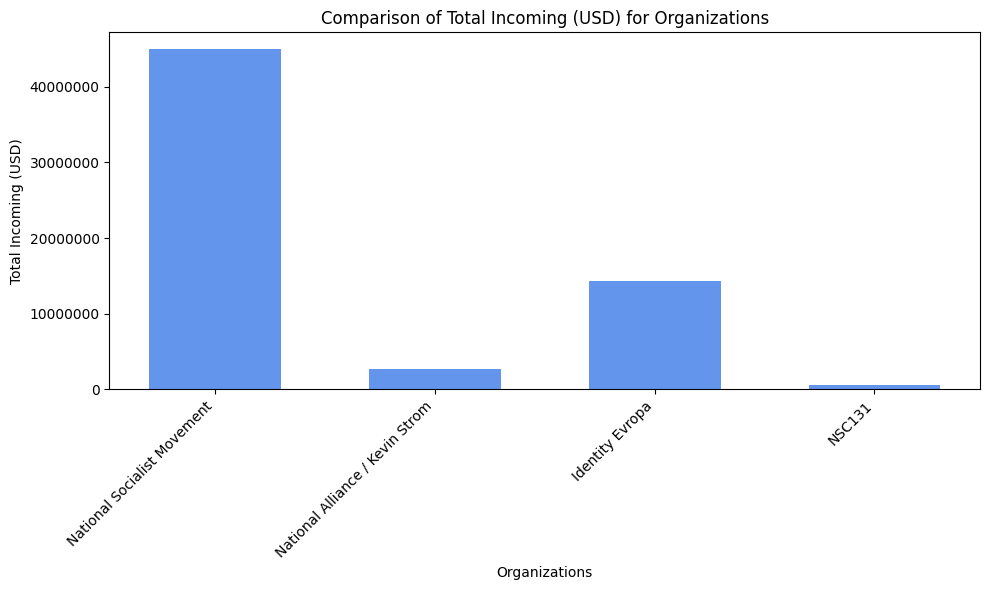

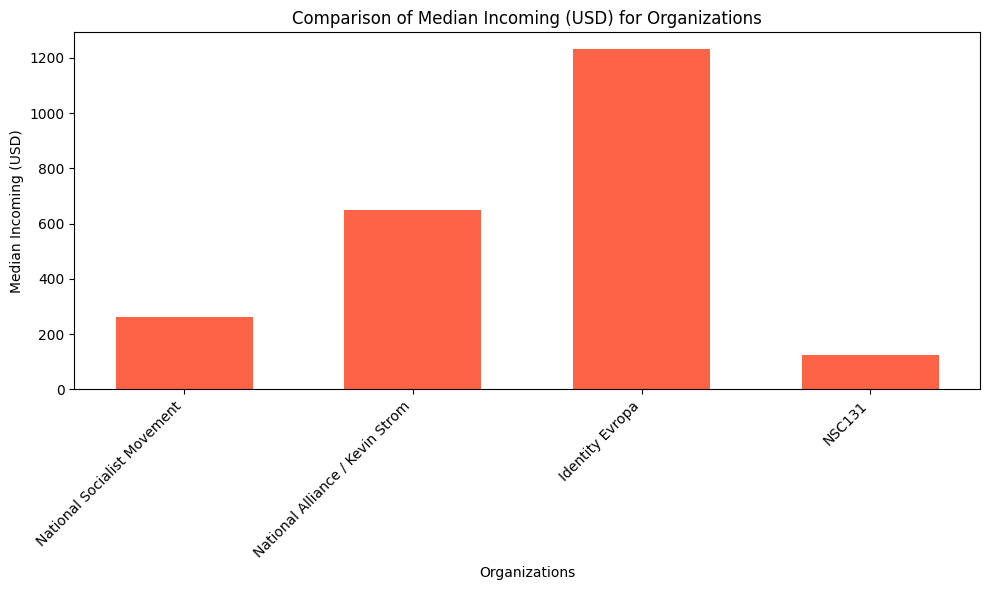

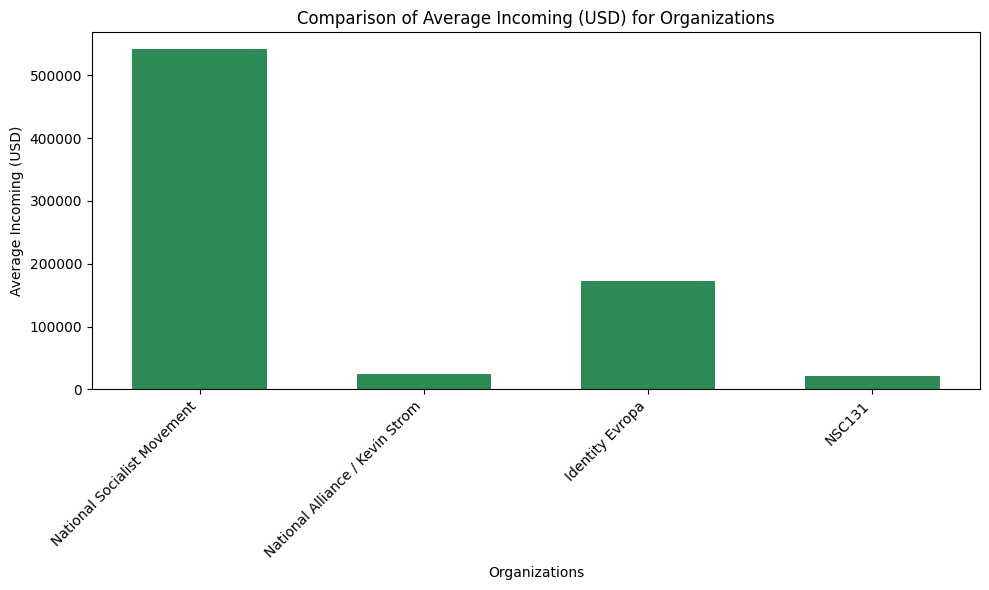

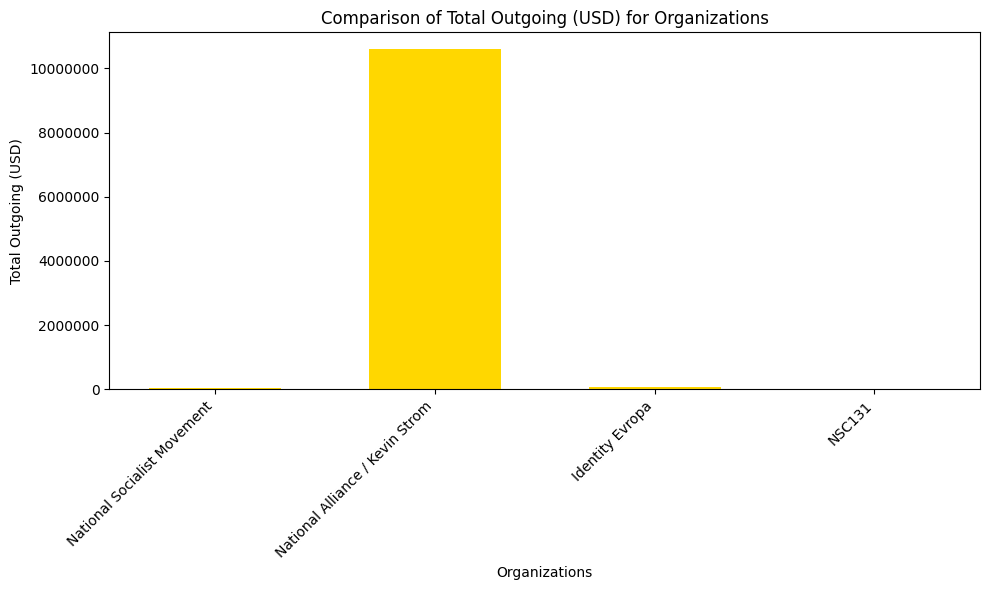

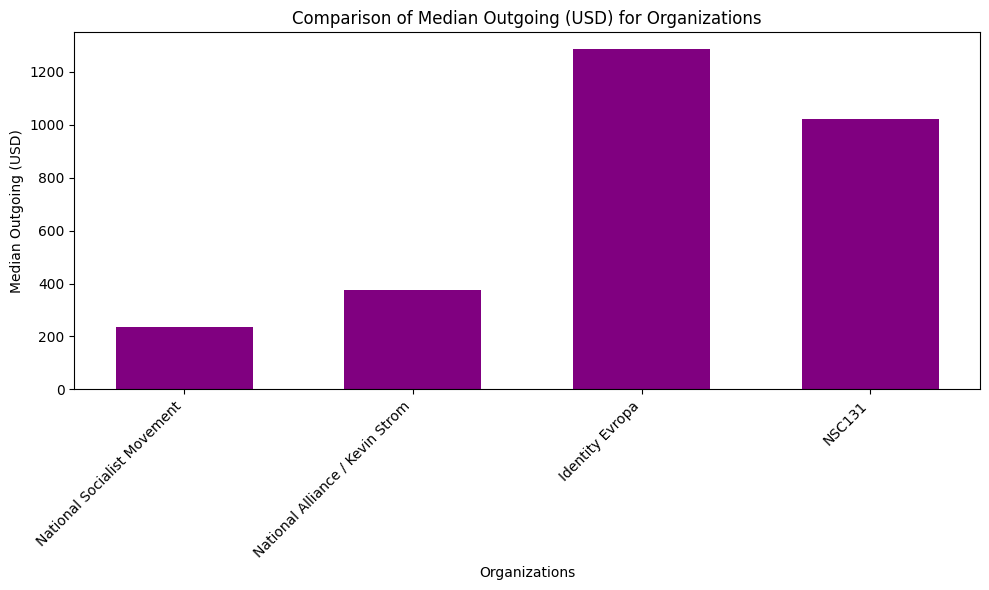

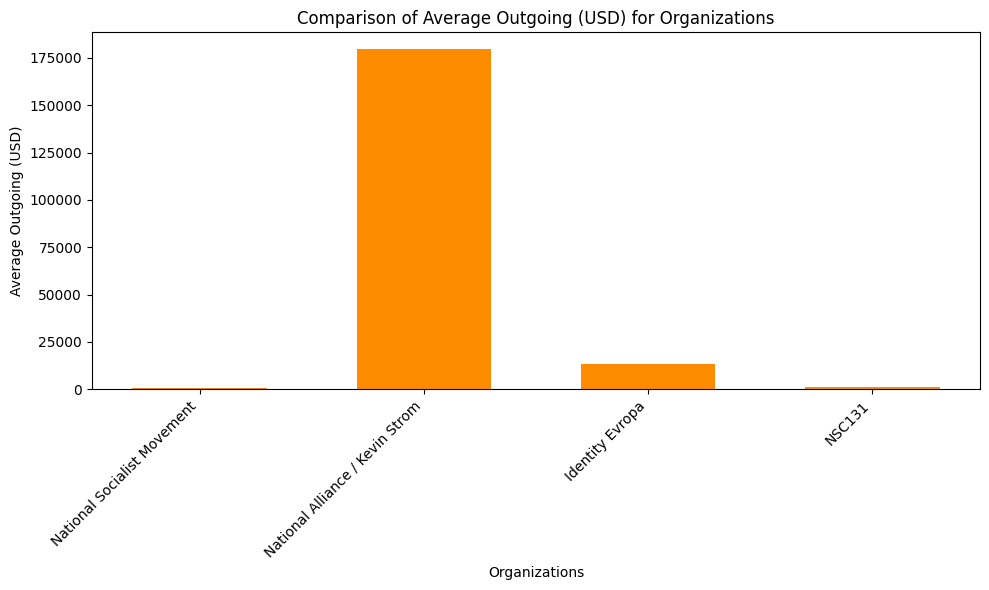

In [39]:
# Example usage:
organizations = ['National Socialist Movement', 'National Alliance / Kevin Strom', 'Identity Evropa', 'NSC131', 'Cybernazi']
main(organizations)

Nationalist Socialist Movement
National Alliance / Kevin Storm
Identity Evropa
NSC131
CyberNazi

<ipython-input-32-fe83e1e9cdd8>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(org_names, rotation=45, ha='right')


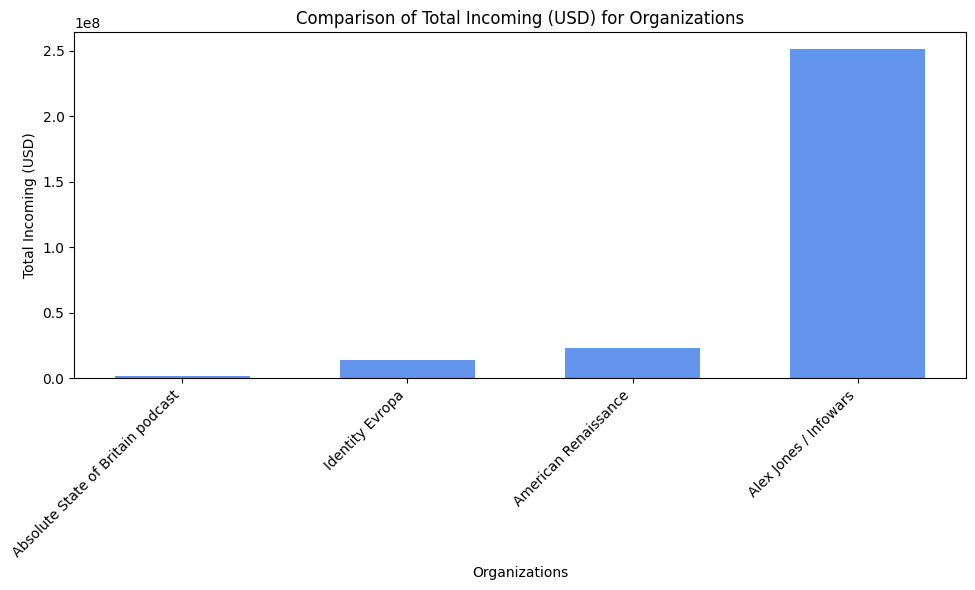

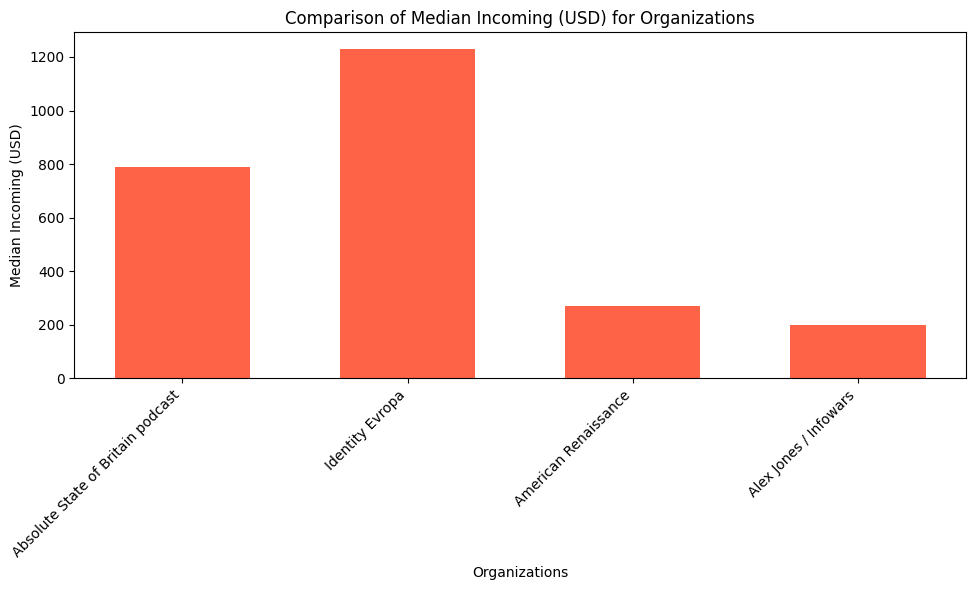

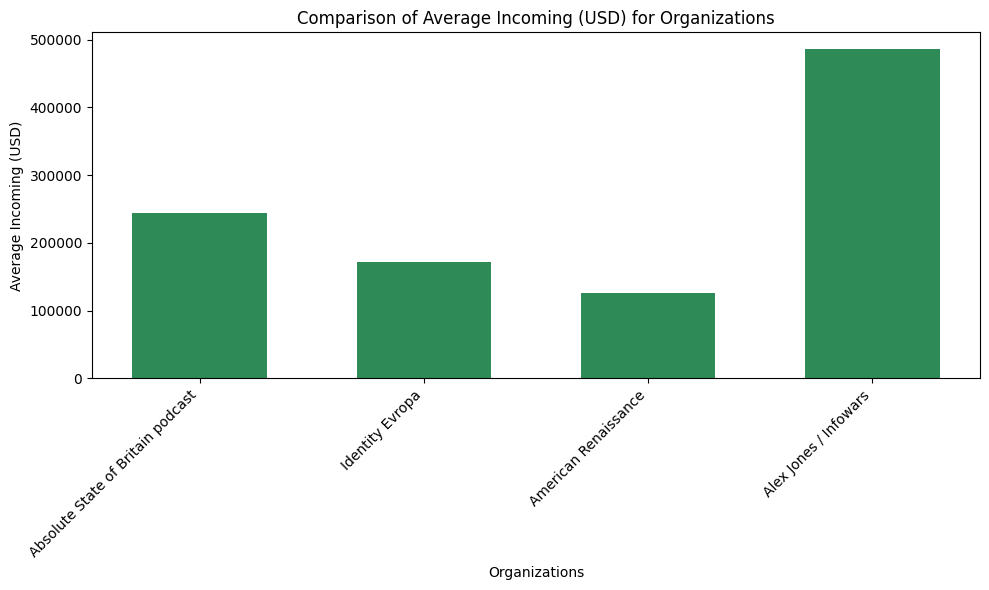

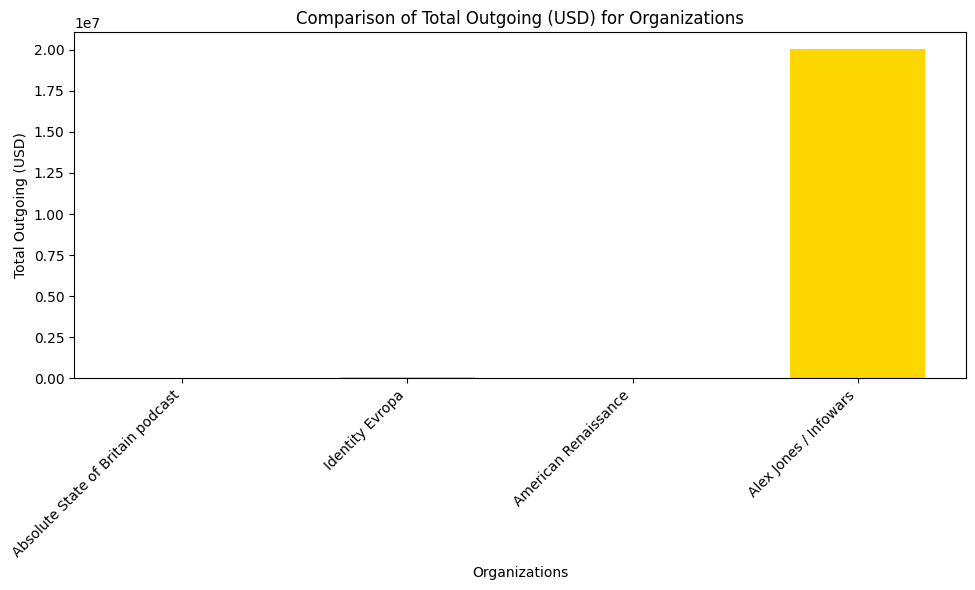

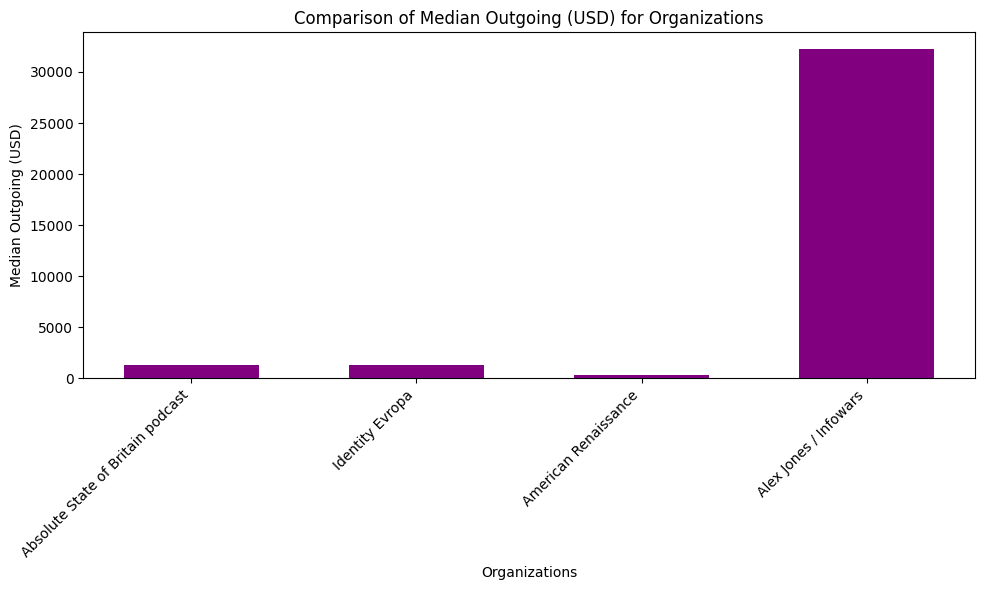

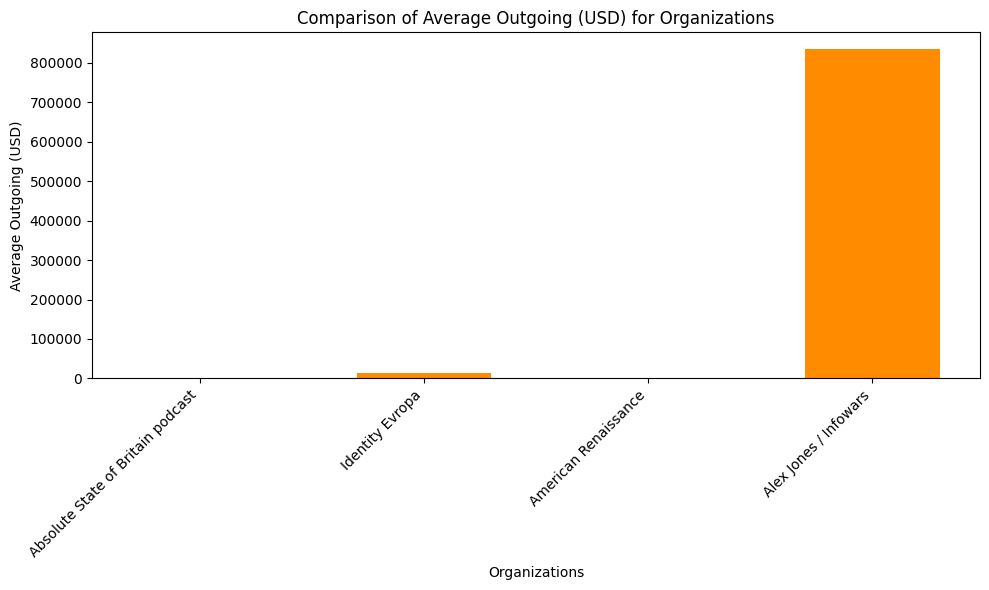

In [35]:

# Example usage:
organizatio = ['Absolute State of Britain podcast', 'Identity Evropa', 'American Renaissance', 'Alex Jones / Infowars']  # Replace with actual organization names
main(organizatio)